In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

from epuc.helpers import SineRegressionDataset, sine_fct_prediction
from epuc.model import RegressorModel, NIGNN
from epuc.losses_nig import inner_loss_der, outer_loss_der, NegativeLogLikelihoodLoss
from epuc.train import train_model, train_muliple_models_primary_nig
from epuc.sampling import sample_normal_params_from_normal_inverse_gamma, sample_normal_params_from_nig_vectorised

plt.style.use('seaborn-v0_8')

# Synthetic Experiments on the Validity of Deep Evidential Regression fro Uncertainty Estimation

### Simple Regression Setting

In [2]:
# set paraemters
N_ITER = 100
N_EPOCHS = 1000
LR = 0.001
lambda_reg = 0.1
N_SAMPLES = 1000
BATCH_SIZE = 128

# losses 
loss_primary = NegativeLogLikelihoodLoss()
loss_secondary_outer = outer_loss_der(lambda_reg=0.0)
loss_secondary_inner = inner_loss_der(lambda_reg=0.0)


Toy data: 

In [3]:
dataset_eval = SineRegressionDataset(n_samples=N_SAMPLES, x_max = 0.5, n_samples_2=10,
                                     eps_var=0.03)

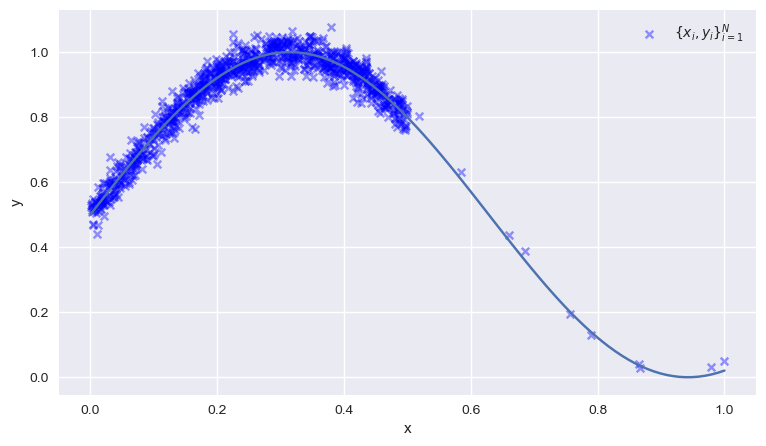

In [4]:
fig, ax = plt.subplots(figsize=(9,5))
x_inst = dataset_eval.x_inst
y_targets = dataset_eval.y_targets

# plot function which generates targets
x = np.linspace(0,1,100)
y = sine_fct_prediction(x, freq=dataset_eval.sine_factor)

ax.set_xlabel("x")
ax.set_ylabel("y")


plt.plot(x,y)
plt.scatter(x_inst, y_targets, s=30, marker="x", color="blue", alpha=0.4, label="$\{x_i, y_i\}_{i=1}^N$")
plt.legend()

In [16]:
# test: train a primary model with Negative Log Likelihood
model = RegressorModel()
dataset = SineRegressionDataset(n_samples=1000, x_max=0.5, n_samples_2=10, eps_var=0.03)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model_out = train_model(model, dataloader=dataloader, criterion=loss_primary, n_epochs=N_EPOCHS, optim=optimizer)


torch.Size([100, 1])


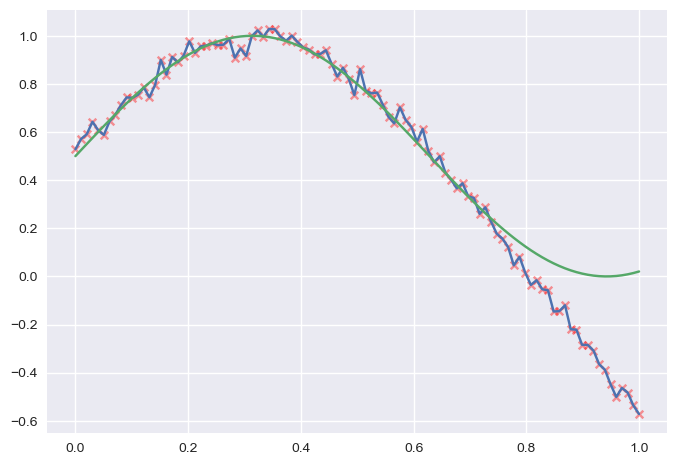

In [17]:
x_eval = np.array(np.linspace(0,1,100))
print(torch.from_numpy(x_eval).reshape(-1,1).shape)
mu, sigma = model_out(torch.from_numpy(x_eval).reshape(-1,1).float())

# sample from induced normal distribution
y_targets = torch.normal(mean=mu, std=sigma)
plt.scatter(x_eval, y_targets.detach().numpy().squeeze(), s=30, marker="x", color="red", alpha=0.4)
plt.plot(x_eval, y_targets.detach().squeeze())
plt.plot(x,y)

In [18]:
results, x_inst = train_muliple_models_primary_nig(dataset=SineRegressionDataset, n_samples=N_SAMPLES,
                                                   n_samples_2=10,
                                                   x_max=0.5, loss=loss_primary, batch_size=BATCH_SIZE,
                                                   eps_var=0.003, lr=LR, n_epochs=N_EPOCHS,
                                                   n_runs=N_ITER)

In [29]:
# calculate confidence bounds for predictions
lower_quantile = np.percentile(results, 2.5, axis=0)
upper_quantile = np.percentile(results, 97.5, axis=0)

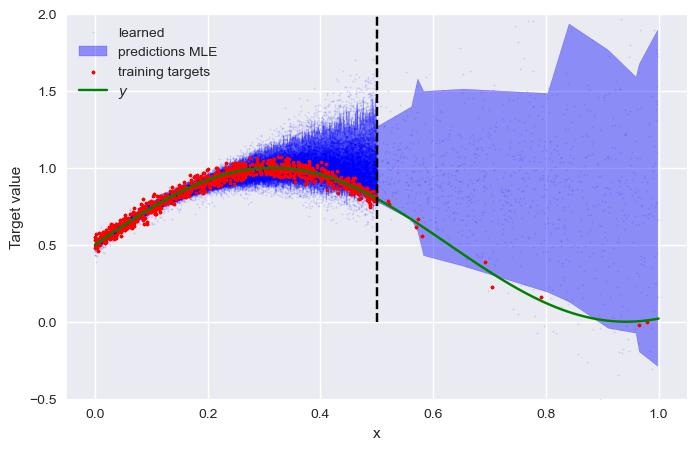

In [45]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.scatter(x_inst, results, alpha=0.1, s=1, color="blue", label="learned")
ax.fill_between(x_inst[0,:], lower_quantile, upper_quantile, color="blue", alpha=0.4, label="predictions MLE")
ax.scatter(dataset.x_inst.numpy().squeeze(), dataset.y_targets.numpy().squeeze(), s=3, color="red",
           marker="x", label="training targets")
ax.set_ylabel("Target value")
ax.set_xlabel("x")
plt.plot(x,y, color="green", label="$y$")
ax.vlines(0.5, 0, 2, color="black", linestyles="--")
ax.set_ylim(-0.5, 2.0)

plt.legend()

### train with secondary loss optimisation

1. Inner Expectation Minimization

In [15]:
model = NIGNN()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
dataset = SineRegressionDataset(n_samples=N_SAMPLES, x_max=0.5, n_samples_2=10, eps_var=0.03)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
model_out = train_model(model, dataloader=dataloader, criterion=loss_secondary_outer, n_epochs=N_EPOCHS, optim=optimizer)

In [6]:
x_eval = np.array(np.linspace(0, 1, 1000))
print(torch.from_numpy(x_eval).reshape(-1, 1).shape)
gamma, nu, alpha, beta = model_out(torch.from_numpy(x_eval).reshape(-1, 1).float())

print(gamma.shape)
print(nu.shape)
print(alpha.shape)
print(beta.shape)
# sample 100 times parameters of normal distribution from normal inverse gamma
mus, sigmas = sample_normal_params_from_nig_vectorised(
    n_samples=N_ITER, gammas=gamma.detach().squeeze(), nus=nu.detach().squeeze(),
      alphas=alpha.detach().squeeze(), betas=beta.detach().squeeze()
)
len(mus) 

torch.Size([1000, 1])
torch.Size([1000, 1])
torch.Size([1000, 1])
torch.Size([1000, 1])
torch.Size([1000, 1])


100

[30.41602905 26.56866374 27.16299955 31.86861213 30.46800764 34.12499146
 28.69688923 30.99995927 30.07318851 31.02155125 31.64656956 32.22973532
 27.43084578 29.32743881 29.95965208 28.00452002 32.06883242 26.50368435
 29.66242071 30.2823431  30.56194399 29.41962744 27.86490263 29.15311791
 27.70512844 26.7675667  34.68334793 30.97122294 28.38781996 33.56716037
 28.26593672 29.91749343 30.63413937 29.21050971 30.93935928 25.93821645
 32.57921726 30.3555154  25.99438181 26.45749939 30.64928942 31.2981833
 28.43793782 33.30433318 28.24708115 30.12471799 29.23160964 30.88793101
 28.88309215 25.08226155 27.83777635 30.40196851 32.37384798 24.55844693
 28.26308574 26.87231209 27.07137515 32.24251307 27.83466608 29.30809784
 29.09408805 31.74297756 29.09154693 27.32979282 32.12564748 28.54360719
 26.14166633 26.2154273  31.86743582 26.85014255 27.23558636 27.73603301
 29.58858196 28.33435475 25.25903242 28.119497   25.85294902 26.33985761
 30.90498896 27.61673949 30.58896553 30.07675244 29.

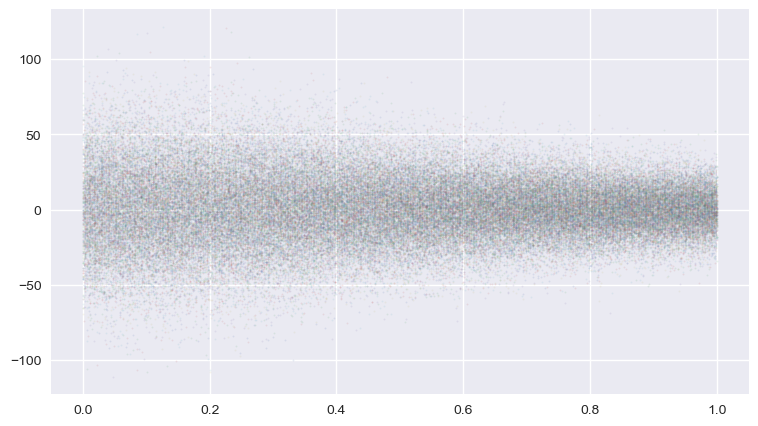

In [9]:
fig, ax = plt.subplots(figsize=(9,5))

for iter in range(len(mus)):
    # sample targets from normal distribution
    mu, sigma = mus[iter], sigmas[iter]
    y_target = np.random.normal(mu, sigma)

    ax.scatter(x_eval, y_target, s=1, alpha=0.1)
